<font size=5>Machine Learning Model Diagnostics and Validation</font>

Updated on July 22, 2022

This demo (based on BikeSharing data, a regression task) covers: 

- Accuracy, WeakSpot and Overfit

- Reliability Testing

- Robustness and Resilience Testing

- Model Comparison and Benchmarking

# Install PiML Toolbox

- Run `!pip install piml` to install the latest version of PiML.
- In Google Colab, we need restart the runtime in order to use newly installed version.

In [ ]:
!pip install piml

# Load and Prepare Data

- Initilaize a new experiment by `piml.Experiment()`
- Low-code interactive interface, or
- High-code autorun scripts (optional)  

In [2]:
from piml import Experiment
exp = Experiment()

## Low-code Interface

In [ ]:
# Choose BikeSharing
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
# Exclude these features one-by-one: "season", "workingday", "atemp" (highly correlated with others)
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [ ]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## High-code Scripts (optional)

In [3]:
exp.data_loader(data='BikeSharing')

exp.data_summary(feature_type={}, feature_exclude=["season", "workingday", "atemp"])

exp.data_prepare(target='cnt', task_type='regression', test_ratio=0.2, random_state=0)

exp.eda(show='all', uni_feature='temp', bi_features=['hr', 'cnt'],  multi_type='correlation_heatmap')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

season   yr  mnth    hr  holiday  weekday  workingday  weathersit  \
0         1.0  0.0   1.0   0.0      0.0      6.0         0.0         1.0   
1         1.0  0.0   1.0   1.0      0.0      6.0         0.0         1.0   
2         1.0  0.0   1.0   2.0      0.0      6.0         0.0         1.0   
3         1.0  0.0   1.0   3.0      0.0      6.0         0.0         1.0   
4         1.0  0.0   1.0   4.0      0.0      6.0         0.0         1.0   
...       ...  ...   ...   ...      ...      ...         ...         ...   
17374     1.0  1.0  12.0  19.0      0.0      1.0         1.0         2.0   
17375     1.0  1.0  12.0  20.0      0.0      1.0         1.0         2.0   
17376     1.0  1.0  12.0  21.0      0.0      1.0         1.0         1.0   
17377     1.0  1.0  12.0  22.0      0.0      1.0         1.0         1.0   
17378     1.0  1.0  12.0  23.0      0.0      1.0         1.0         1.0   

       temp   atemp   hum  windspeed    cnt  
0      0.24  0.2879  0.81     0.0000   16.0  
1      0.22  0.2727  0.80     0.0000   40.0  
2      0.22  0.2727  0.80     0.0000   32.0  
3      0.24  0.2879  0.75     0.0000   13.0  
4      0.24  0.2879  0.75     0.0000    1.0  
...     ...     ...   ...        ...    ...  
17374  0.26  0.2576  0.60     0.1642  119.0  
17375  0.26  0.2576  0.60     0.1642   89.0  
17376  0.26  0.2576  0.60     0.1642   90.0  
17377  0.26  0.2727  0.56     0.1343   61.0  
17378  0.26  0.2727  0.65     0.1343   49.0  

[17379 rows x 13 columns]

HTML(value='Data Shape:(17379, 13)')

0                            1
0  Inactive columns name  [season, workingday, atemp]
1     Target colunm name                          cnt
2              Task type                   Regression
3             Test ratio                          0.2
4           Random state                            0

<IPython.core.display.Javascript object>

# Train Black-Box Models 

e.g. XGBoost (depth 7)

In [4]:
from xgboost import XGBRegressor
model = xgb.XGBRegressor(max_depth=7, n_estimators=500)
exp.model_train(model, name='XGBoost')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register XGBoost7 Done</p>")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

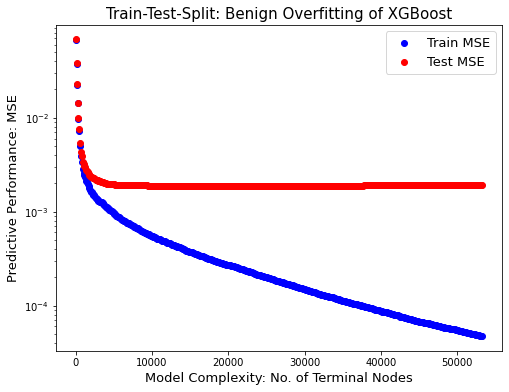

In [5]:
# Benign Overftting under train-test-split framework

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error

train_x, train_y = exp.get_model("XGBoost7").get_data(train=True)
test_x, test_y = exp.get_model("XGBoost7").get_data(test=True)

def score(clf, iteration_range):
    train_mse = mean_squared_error(train_y, clf.predict(train_x, iteration_range=iteration_range))
    test_mse = mean_squared_error(test_y, clf.predict(test_x, iteration_range=iteration_range))
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'train_mse': train_mse, 'test_mse': test_mse}

all_metrics = []
xgbinfo = clf.get_booster().trees_to_dataframe()
n_iter = 500
for i in range(n_iter):
    metrics = score(clf, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

plt.figure(figsize=(8,6))
plt.scatter(all_resluts["n_leaves"], all_resluts["train_mse"], color="blue", label="Train MSE")
plt.scatter(all_resluts["n_leaves"], all_resluts["test_mse"], color="red", label="Test MSE")
plt.legend(fontsize=13)
plt.yscale("log")
plt.ylabel("Predictive Performance: MSE", fontsize=13)
plt.xlabel("Model Complexity: No. of Terminal Nodes", fontsize=13)
plt.title("Train-Test-Split: Benign Overfitting of XGBoost", fontsize=15)
plt.show()

In [6]:
# Choose XGBoost7, check Overfit
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Train Intepretable Models


In [7]:
# ----------------------------------
# Low-code Interface
# ----------------------------------

# Choose EBM, GAMI-Net, ReLU-DNN (default) and Sparse-ReLU-DNN (L1=0.0005)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [8]:
# ----------------------------------
# High-code Scripts (optional)
# ----------------------------------

# EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_table')

# GAMI-Net: GAMI Neural Networks by WF CMoR
from piml.models import GAMINetRegressor

clf = GAMINetRegressor(interact_num=10, 
                       subnet_size_main_effect=[20], 
                       subnet_size_interaction=[20, 20])
exp.model_train(model=clf, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

# ReLU-DNN: ReLU Deep Neural Networks (default parameters)
from piml.models import ReluDNNRegressor

clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

# Sparse-ReLU-DNN: set L1-Regularization to be 0.005
clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=0.0005,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='Sparse-ReLU-DNN')
exp.model_diagnose(model="Sparse-ReLU-DNN", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

MSE       MAE        R2
0  Train  0.006317  0.055269  0.816823
1   Test  0.006871  0.057656  0.804265
2    Gap  0.000554  0.002387 -0.012558

HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

MSE       MAE        R2
0  Train  0.003238  0.039444  0.906110
1   Test  0.003597  0.041875  0.897519
2    Gap  0.000360  0.002431 -0.008591

HTML(value="<p class='notification info'>Register ReLU-DNN Done</p>")

MSE       MAE        R2
0  Train  0.003915  0.043008  0.886470
1   Test  0.004556  0.046019  0.870214
2    Gap  0.000641  0.003011 -0.016256

HTML(value="<p class='notification info'>Register Sparse-ReLU-DNN Done</p>")

MSE       MAE        R2
0  Train  0.015368  0.090600  0.554361
1   Test  0.015395  0.089218  0.561412
2    Gap  0.000028 -0.001382  0.007052

# Interpret/Explain

In [9]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [10]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN, as well as arbitrary black-box models upon registration
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Diagnose/Compare

In [11]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [12]:
# Compare EBM, GAMI-Net and XGBoost7
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>